<a href="https://colab.research.google.com/github/zaman69/deep_learning_codes-_projects/blob/main/Tweet_Emotion_Recognition_Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**📌 Project Overview**



This project is about building a deep learning model that can detect emotions in short texts (tweets). We use TensorFlow and a public dataset called "emotion" from Hugging Face's datasets library.

1. Dataset Loading
Instead of downloading data manually, we use Hugging Face's load_dataset() function. It automatically fetches and prepares the "emotion" dataset, which includes labeled tweets across six emotions: sadness, joy, love, anger, fear, surprise.

2. Data Preprocessing
We extract:

tweets: the actual text data.

labels: the emotion categories (as integers, like 0 to 5).

We tokenize the text using TensorFlow’s Tokenizer, which:

Converts words into numbers.

Keeps only the top 10,000 most frequent words.

Replaces unknown words with a special <UNK> token.

3. Sequence Padding
Neural networks expect all input sequences to be of the same length. So, we use pad_sequences() to ensure every tweet has a fixed length (e.g., 50 words), padding shorter ones with zeros.

4. Label Mapping
We create dictionaries to:

Convert emotion labels to numeric indices (e.g., 'joy' → 1).

Convert predicted indices back to emotion names (1 → 'joy').
This helps both during model training and when interpreting predictions.

5. Model Building
We use a Sequential model with the following layers:

Embedding Layer: Converts word IDs into dense vectors (word meanings).

Two Bidirectional LSTM Layers: These read the text both forward and backward for better context understanding.

Dense Softmax Output Layer: Predicts one of 6 emotion classes with probability.

6. Model Compilation
We compile the model with:

sparse_categorical_crossentropy loss (because labels are integers, not one-hot vectors).

adam optimizer (automatically adjusts learning rate).

accuracy as the evaluation metric.

7. Model Training
We train the model using .fit():

Provide training and validation data.

Use EarlyStopping to stop training if validation accuracy doesn’t improve after 2 epochs (prevents overfitting).

8. Prediction and Evaluation
Instead of predict_classes() (which is removed in TensorFlow 2.6+), we use:

model.predict() to get class probabilities.

np.argmax() to find the predicted class with the highest probability.

We then map the numeric prediction back to the emotion label for interpretation.

✅ Outcome
At the end of training, you have a working LSTM-based model that can take a tweet as input and predict the underlying emotion with decent accuracy.

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

Created for Coursera guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/learn/tweet-emotion-tensorflow)

---

## Task 1: Introduction


## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries



✅ What it does:
This is a Jupyter/Colab magic command used to run shell commands inside a notebook cell.

pip install nlp installs the nlp package, which is the old name of Hugging Face's datasets library.

In [1]:
!pip install nlp



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [3]:
# ⬇️ Step 1: Install the correct version of fsspec
# fsspec is a library that helps Python work with different file systems (local, cloud, etc.).
# The Hugging Face datasets library uses fsspec internally.
# Some newer versions of fsspec break compatibility with datasets due to changes in how wildcards like '*' are handled.
# So, we are installing an older but stable version that is known to work well with datasets.
!pip install fsspec==2023.6.0

# ⬇️ Step 2: Install the Hugging Face datasets library (specific version)
# This library provides access to 1000+ NLP and ML datasets like "emotion", "imdb", "ag_news", etc.
# We are using version 2.14.5 because it is stable and compatible with the fsspec version above.
# Newer versions may cause errors when loading some datasets.
!pip install datasets==2.14.5




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.6.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64

In [5]:


# Import the load_dataset function from the Hugging Face 'datasets' library.
# This function is used to automatically download and load popular datasets for machine learning and NLP tasks.
from datasets import load_dataset

# Load the 'emotion' dataset from Hugging Face's dataset hub.
# This dataset contains English text samples (like tweets) labeled with one of six basic emotions:
# sadness, joy, love, anger, fear, and surprise.
# The dataset will be downloaded the first time and cached for future use.
dataset = load_dataset("emotion")




In many traditional machine learning projects, we manually download datasets from sources like Kaggle, unzip the files, and then load them using tools like pandas. However, in this project, we're using the Hugging Face datasets library, which simplifies the entire process. By calling load_dataset("emotion"), the library automatically fetches the dataset named "emotion" from the Hugging Face Hub, downloads and caches it, and returns a ready-to-use structured dataset. This means we don’t have to handle CSV files, folder structures, or manual parsing. It saves time and ensures consistency, especially for popular NLP datasets that are already cleaned and well-formatted for training and evaluation.



In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [9]:
# ✅ Function: get_tweets
# Purpose: This function takes a dataset (usually a split like 'train', 'test', or 'validation' from Hugging Face)
# and extracts the input text (tweets) and their corresponding emotion labels into two separate lists.

def get_tweets(data):
    # 📝 Extracting all the tweet texts from the dataset
    # Each item in 'data' is a dictionary with keys like 'text' and 'label'
    # We loop through the dataset and collect the value associated with the 'text' key from each dictionary
    tweets = [x['text'] for x in data]

    # 🏷️ Extracting all the labels from the dataset
    # Similarly, we loop through the dataset and collect the value of the 'label' key
    # These labels are integers that represent emotion categories (e.g., 0 = sadness, 1 = joy, etc.)
    labels = [x['label'] for x in data]

    # 🔁 Return two lists:
    # - 'tweets': a list of all the input text strings (used as input for ML models)
    # - 'labels': a list of all emotion category labels (used as target/output for training)
    return tweets, labels


In [10]:
tweets, labels = get_tweets(train)

In [11]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')

tokenizer.fit_on_texts(tweets)

print(tokenizer.texts_to_sequences([tweets[0]]))

[[2, 139, 3, 679]]


## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

📊 What This Code Does (in plain words):
Measures how long each tweet is (in words).

Draws a histogram to show which tweet lengths are most common.

Helps you decide things like max sequence length for padding (e.g., most tweets are under 30 words).

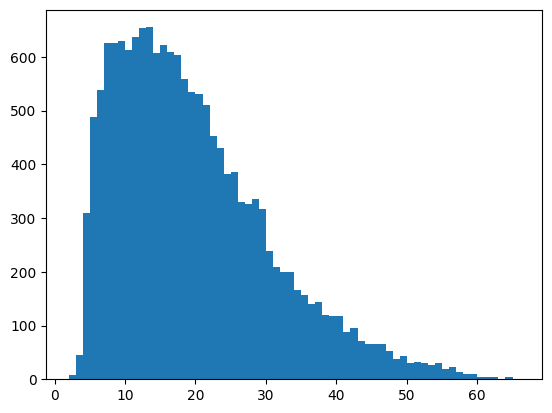

In [16]:
# Count the number of words in each tweet
# We split each tweet by space (' ') to get words, then take the length of each list
# This gives us a list of tweet lengths (i.e., how many words per tweet)
lengths = [len(t.split(' ')) for t in tweets]

# Plot a histogram to see the distribution of tweet lengths
# 'bins=len(set(lengths))' ensures we get one bin per unique tweet length
plt.hist(lengths, bins=len(set(lengths)))

# Show the histogram plot
plt.show()

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [18]:
def get_sequences(tokenizer, tweets):
    sequences = tokenizer.texts_to_sequences(tweets)
    padded_sequences = pad_sequences(sequences, truncating='post', maxlen=50, padding='post')
    return padded_sequences

In [19]:
padded_train_sequences = get_sequences(tokenizer, tweets)

In [20]:
padded_train_sequences[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [21]:
classes = set(labels)
print(classes)

{0, 1, 2, 3, 4, 5}


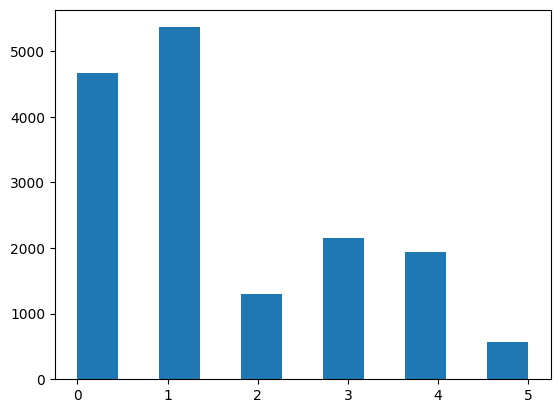

In [22]:
plt.hist(labels, bins=11)
plt.show()

In [23]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_classes = dict((v, k) for k, v in classes_to_index.items())

In [24]:
classes_to_index

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [25]:
index_to_classes

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [26]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [27]:
train_labels = names_to_ids(labels)
print(train_labels[0])

0


🔍 What's Going On Here?
You have a list of labels:

python
Copy
Edit
labels = [0, 1, 2, 3, 4, 5, 0, 1, 2, ...]
These numbers represent emotions (like "joy", "anger", etc.).

Even though these are already numbers, your code is building a system to convert labels to numbers and back — because in many datasets, the labels might be words (like "happy", "sad", etc.), not numbers.

You're building 3 things:

✅ 1. classes_to_index
python
Copy
Edit
classes_to_index = dict((c, i) for i, c in enumerate(classes))
This means:
For every unique class (label), give it a number.

Since your classes are already numbers {0, 1, 2, 3, 4, 5}, you’re just doing:

python
Copy
Edit
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
If your classes were:

python
Copy
Edit
{"joy", "anger", "sadness"}
Then it would become something like:

python
Copy
Edit
{'joy': 0, 'anger': 1, 'sadness': 2}
✅ 2. index_to_classes
python
Copy
Edit
index_to_classes = dict((v, k) for k, v in classes_to_index.items())
This reverses the previous dictionary. It tells you:

“If the model gives you 2, what emotion is that?”

So:

python
Copy
Edit
{0: 0, 1: 1, ..., 5: 5}
Or in case of words:

python
Copy
Edit
{0: 'joy', 1: 'anger', 2: 'sadness'}
✅ 3. names_to_ids
python
Copy
Edit
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])
Let’s break this down:

labels is your list of labels, like [0, 2, 4, 1, 3]

classes_to_index.get(x) means: “Look up the number for this label”

⚙️ This function changes all labels into numbers using classes_to_index.

📌 In your case, it doesn't change anything — but if labels were words, it would change them into numbers.

✅ 4. Convert the labels
python
Copy
Edit
train_labels = names_to_ids(labels)
This runs the function and gives you a new list of labels (as numbers), ready to use for model training.

🧠 Why Do All This?
Because in other datasets, your labels might look like this:

python
Copy
Edit
labels = ['happy', 'angry', 'sad', 'happy', 'angry']
You can't train a model with words — you must first turn them into numbers.

So this system:

Converts: 'happy' → 0, 'angry' → 1, 'sad' → 2 → ✅

Trains your model → ✅

Converts back: 0 → 'happy' when showing predictions → ✅

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

✅ Model Architecture Explanation:

model = tf.keras.models.Sequential([
You're using a Sequential model, which stacks layers one after another.


tf.keras.layers.Embedding(10000, 16, input_length=50),

This is an Embedding layer. It turns each word (represented by an integer) into a dense vector.

10000 = Vocabulary size (i.e., max 10,000 unique words).

16 = Each word will be represented as a 16-dimensional vector.

input_length=50 = Each tweet is padded/truncated to 50 words.

📌 Think of this as converting word IDs → word meanings (vectors).


    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
This is a Bidirectional LSTM layer with 20 units.

It reads the sequence forward and backward, giving it better understanding of context.

return_sequences=True → It passes all time steps' outputs to the next LSTM layer (not just the last one).

    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
Another Bidirectional LSTM, but now it returns only the last output.

This captures the full context of the tweet up to the end.


    tf.keras.layers.Dense(6, activation='softmax')
])
This is the output layer.

6 = Number of emotion classes.

softmax = Gives probabilities for each class (they’ll all add up to 1).

✅ Compilation

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
loss='sparse_categorical_crossentropy': Used because your labels are integers (not one-hot encoded).

optimizer='adam': A smart optimizer that adjusts learning rates automatically.

metrics=['accuracy']: To track how often the prediction is correct.

In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [29]:
val_tweets, val_labels = get_tweets(val)
val_sequences = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [30]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 np.int64(0))

In [31]:
h = model.fit(
    padded_train_sequences, train_labels,
    validation_data=(val_sequences, val_labels),
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - accuracy: 0.3822 - loss: 1.5358 - val_accuracy: 0.6925 - val_loss: 0.8828
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.7653 - loss: 0.6834 - val_accuracy: 0.7970 - val_loss: 0.6226
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.8905 - loss: 0.3359 - val_accuracy: 0.8675 - val_loss: 0.4165
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 59ms/step - accuracy: 0.9425 - loss: 0.1903 - val_accuracy: 0.8810 - val_loss: 0.3715
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - accuracy: 0.9642 - loss: 0.1249 - val_accuracy: 0.8825 - val_loss: 0.3911
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 61ms/step - accuracy: 0.9718 - loss: 0.0959 - val_accuracy: 0.8935 - val_loss: 0.3609
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.9792 - loss: 0.0708 - val_accuracy: 0.8930 - val_loss: 0.3561
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 58ms/step - accuracy: 0.9818 - loss: 0.0570 - 

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

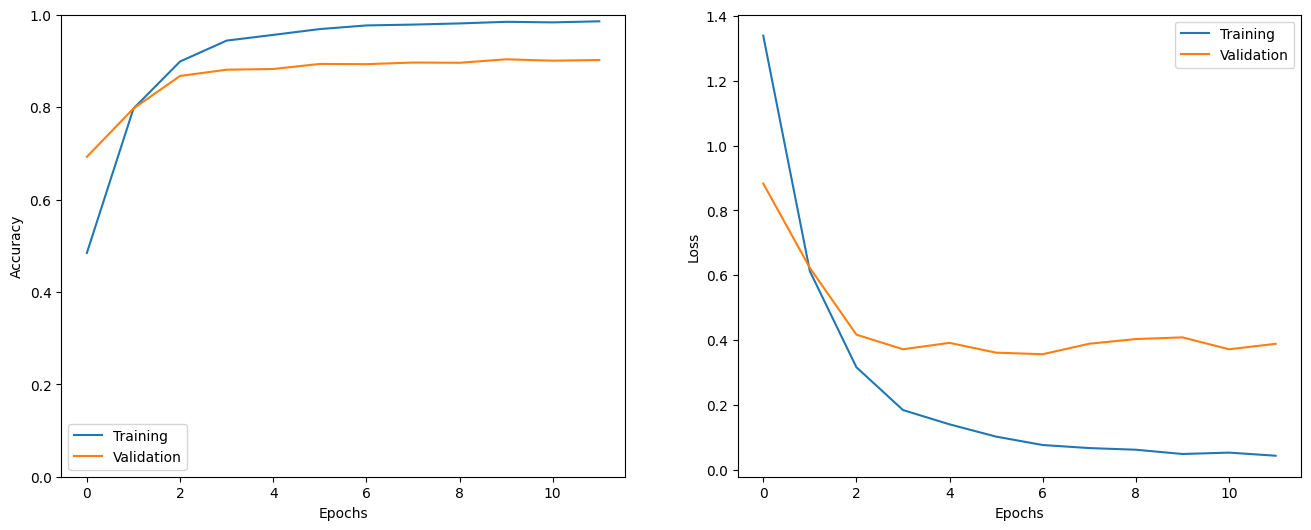

In [32]:
show_history(h)

In [33]:
test_tweets, test_labels = get_tweets(test)
test_sequences = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [34]:
_ = model.evaluate(test_sequences, test_labels)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9010 - loss: 0.3818


In [37]:
import numpy as np
import random

# 👇 Pick a random test example
i = random.randint(0, len(test_labels) - 1)

# 👇 Print the original tweet
print('Sentence:', test_tweets[i])

# 👇 Print the actual emotion label (true answer)
print('True Emotion:', index_to_classes[test_labels[i]])

# 👇 Predict using your model
# Step 1: model.predict() gives you probabilities for each emotion (as a list of 6 numbers)
# Step 2: np.argmax() picks the one with the highest score
probs = model.predict(np.expand_dims(test_sequences[i], axis=0))  # shape becomes (1, 50)
predicted_class = np.argmax(probs[0])  # get the index of the highest score

# 👇 Print the predicted emotion
print('Predicted Emotion:', index_to_classes[predicted_class])


Sentence: i feel like rich purple and gold are a match made in heaven and this reinforces that belief
True Emotion: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Emotion: 1


In [39]:
# Get prediction probabilities for all test sequences
probs = model.predict(test_sequences)

# Get the predicted class (the index of the highest probability) for each prediction
preds = np.argmax(probs, axis=1)

# Check shapes
preds.shape, test_labels.shape


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


((2000,), (2000,))

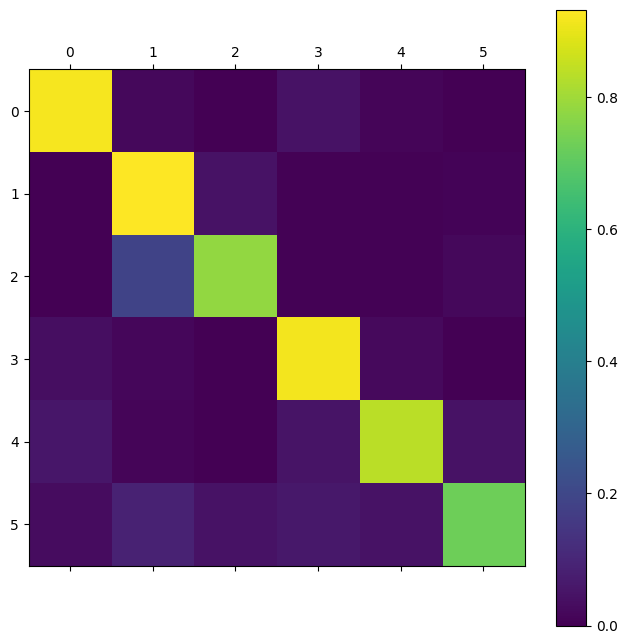

In [40]:
show_confusion_matrix(test_labels, preds, list(classes))